In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq
from scipy.optimize import minimize
from sklearn import datasets
from scipy.stats import multivariate_normal, norm
from scipy.signal import butter, lfilter, freqz, cheby1, sosfilt

In [26]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape

def objective_1D(z, y, A, G, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G
    xc = G.eval(zc)
    Dx = G.jac(zc)

    # directly modifying does not work
    #xc = butter_lowpass_filter(xc,0.2, 1, order = 6)
    #min_val = np.min(np.abs(xc))
    #xc = xc + min_val + 0.1

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc   = Dx.H(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective_1D, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # extract complex values
    zhat = result.x[:n] + 1j*result.x[n:]
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/zhat))
    zhat_corr = np.exp(1j*phi)*zhat
    
    # relative error
    error = np.linalg.norm(zhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, zhat_corr

In [37]:
# easy version: no operators
def MaskedFourier_1D_matrix(M):
    '''
    Masked 1D fourier transform as a large matrix.

    input:
        M - 2D array of size n x m containing m masks of length n (or windows of length n)
    
    output:
        A - a 2D matrix of size n*m x n*m

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    #F = fft(np.eye(nx))
    F = la.dft(nx, scale =None)
    blocks = [F @ np.diag(M[:,i]) for i in range(mx)]

    A = np.vstack(blocks)

    return A

In [3]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    #mv  = lambda x : fft(M*x.reshape((nx,1))).flatten()
    #rmv = lambda y : np.sum(M.conj() * ifft(y.reshape((nx,mx))), axis=1).flatten()

    #mv = lambda x: fft(M * x[:, None], axis=0).flatten()
    #rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()

    # mv = lambda x : fft((M.T @ np.diag(x)).flatten())

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

In [4]:
# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

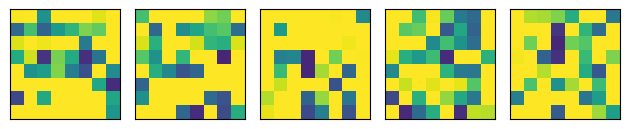

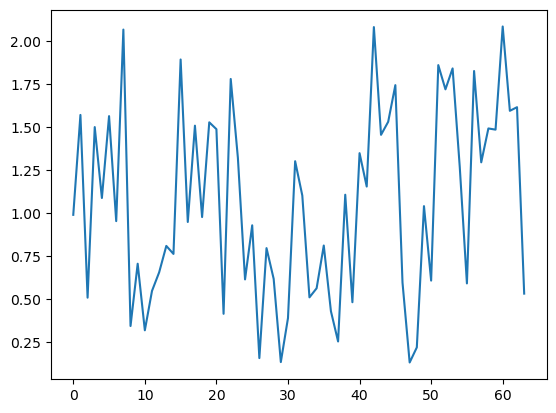

In [ ]:
# create data set of random real positive numbers with threshold delta bounded away from 0

#(digits, cls) = datasets.load_digits(return_X_y=True)
#X = np.ones((183, 64)) + 1j*digits[np.where(cls==3)[0],:]/16 

delta = 0.1
X = np.random.uniform(delta,2+delta,(180,64))

n = X.shape[1]
nx = int(np.sqrt(n))

ns = 5
fig, ax = plt.subplots(1,ns)

# 2D representation
for i in range(ns):
    x = X[i]
    ax[i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    #ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    #ax[1,i].set_xticks([])
    #ax[1,i].set_yticks([])
fig.tight_layout()

#1D representation
plt.figure()
plt.plot(np.linspace(0,n-1,n), X[0])
plt.show()

In [5]:
def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals

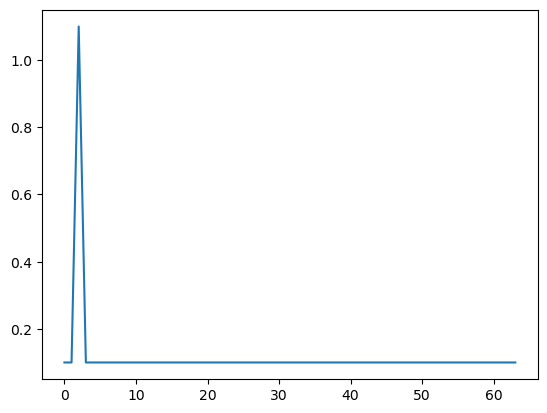

In [6]:
# create data set of a block signal with threshold delta bounded away from 0
delta = 0.1
nsamples = 180
n = 64
nx = int(np.sqrt(n))

heights = np.ones(nsamples)
starts = np.random.randint(0,n-2,nsamples)
widths = np.random.randint(1,n/2,nsamples)
X = block_signal(n,starts,heights,widths)
X = X + delta

domain = np.linspace(0,63,64)
plt.plot(domain,X[20,:])

-0.3180541816404248
0.1


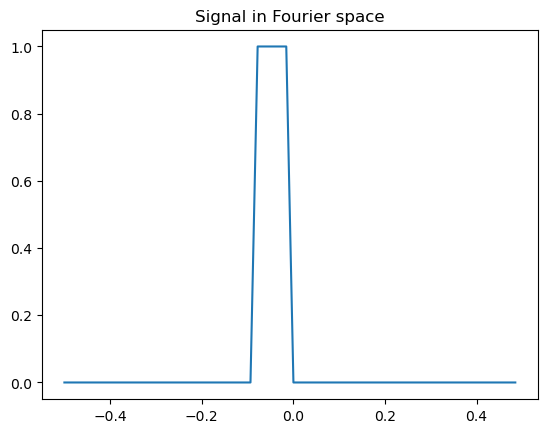

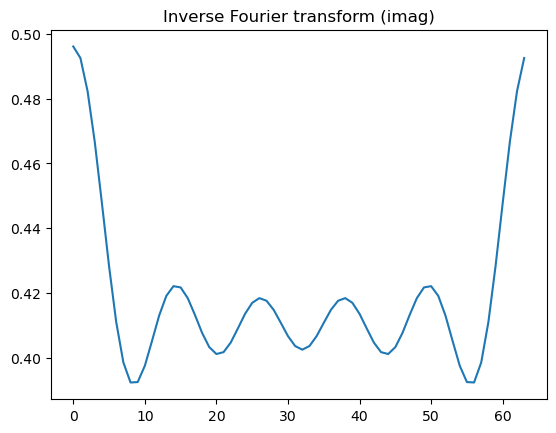

In [ ]:
# use bandlimiting in frequency space (using real part, ifft has real/imaginary part possibly)
Y = ifft(X-delta)
min_value = np.real(Y.min())
print(min_value)
Y = Y + delta + abs(min_value)

print(np.real(Y.min())) # test delta threshold

# plot random index
jndex = 8
amplitudes_X = abs(X[jndex,:]-delta)
k = fftfreq(64,1)
sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes_X = amplitudes_X[sorted_indices]

plt.figure()
plt.title("Signal in Fourier space")
plt.plot(k,amplitudes_X)
plt.show()

plt.figure()
plt.title("Inverse Fourier transform (abs)")
plt.plot(np.linspace(0,n-1,n),np.abs(Y[jndex,:]))
plt.show()

Min. value of ambiguity function of a random mask is  0.004265933500551947
The value of c is 1386.8200252061872
Lowest threshold of the ambiguity function is 0.0007210740988913278
The mask with the lowest ambiguity threshold is 13


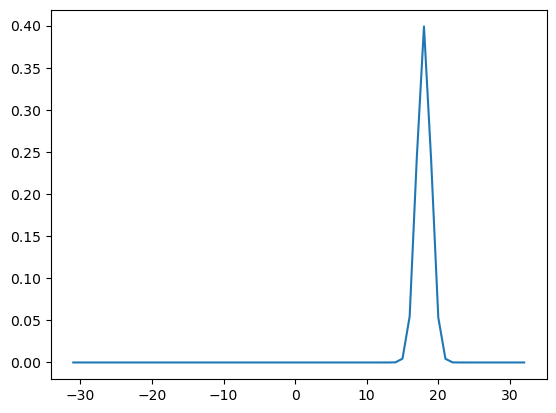

In [7]:
# create window function/mask
mx = 100

domain = np.linspace(-31,32,64)

# describes mx window functions of length n
windows = np.zeros((n,mx))
mu = np.random.uniform(-31,32,100)
windows = norm.pdf(domain[:, np.newaxis], mu, 1) # do not use a high variance, leads to small values ambiguity function

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(windows[:,i])

# ambiguity of windows
mask_test = Ambiguity(windows[:,99], 1)
print("Min. value of ambiguity function of a random mask is ", abs(mask_test).min())

c = 0
for i in range(2):
    for j in range(mx): 
        mask_test = Ambiguity(windows[:,j], i)
        temp_max = 1/abs(mask_test).min()
        if temp_max > c:
            c = temp_max
            remember_mask_index = j
print("The value of c is", c)
print("Lowest threshold of the ambiguity function is", 1/c)
print("The mask with the lowest ambiguity threshold is", remember_mask_index)

plt.plot(domain,windows[:,remember_mask_index])

In [ ]:
MF = MaskedFourier_1D(windows)
print(MF @ xtrue)

MF_matrix = MaskedFourier_1D_matrix(windows)
print(MF_matrix @ xtrue)

##### Make operators

In [20]:
# prior parameters
m = mx * n
delta = 0.1

MF = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

def min_v_conj(z):
    k = np.argmin(np.abs(z))
    if z[k] == 0:
        v_k = 0  # Avoid division by zero
    else:
        v_k = z[k] / np.abs(z[k]) * np.sum(z)
    v = np.zeros_like(z)
    v[k] = v_k
    
    return v

def min_v(z):
    k = np.argmin(np.abs(z))
    if z[k] == 0:
        v = np.zeros_like(z)
        return v  
    else:
        v_k = (z[k]**2) / np.abs(z[k])
    v = v_k * np.ones_like(z)
    
    return v

# define G and I here, currently G can only handle real input (due to Jacobian formulation)
I   = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))
G   = Op(fun = lambda z : z + delta + np.min(np.abs(z)), jac = lambda z : LinearOperator((n, n), matvec = lambda z: z + min_v(z), rmatvec = lambda z : z + min_v_conj(z)), shape = (n,n))

In [47]:
z = xtrue
print(z)
G_z = G.jac(z)
print(G_z)

np.ones_like(z)

[0.26853432 0.2759468  0.29887313 0.33774676 0.3741854  0.38646956
 0.37508094 0.3610012  0.35972444 0.36735962 0.37205254 0.36985785
 0.36593969 0.36530861 0.36735832 0.36875692 0.36821217 0.37740934
 0.45131025 0.68113731 1.07028862 1.4345398  1.55706331 1.44310115
 1.30245852 1.28981357 1.36613264 1.4129714  1.39099941 1.35186017
 1.34558543 1.36607494 1.3800352  1.37457962 1.36343407 1.36120558
 1.36684131 1.37098415 1.3696297  1.3664519  1.36569523 1.36724232
 1.36846734 1.35782612 1.28279738 1.05328441 0.66497109 0.30094554
 0.178027   0.29165676 0.4323735  0.44525628 0.36901035 0.32206397
 0.34393836 0.38309428 0.38943635 0.36897013 0.35498069 0.36040772
 0.37155675 0.37380424 0.36817584 0.36402512]
<64x64 _CustomLinearOperator with dtype=float64>


C:\Users\Ava\AppData\Local\Temp\ipykernel_21012\253393803.py:24: RuntimeWarning: invalid value encountered in scalar divide
  G   = Op(fun = lambda z : z + delta + np.min(np.abs(z)), jac = lambda z : LinearOperator((n, n), matvec = lambda z: z + (np.min(np.abs(z))**2)/np.min(np.abs(z)), rmatvec = lambda z : z + min_v(z)), shape = (n,n))


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

##### Test signal reconstruction for ifft of block signals

In [22]:
xtrue = Y[8,:] 
sigma = 0
#yobs  = np.abs((MF @ xtrue)**2) + sigma*np.random.randn(64*100)
#print(len(yobs))

#val, grad = objective_1D(np.ones(64), yobs, MF)

error, zhat = reconstruct(xtrue, A, I, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.plot(domain, np.real(xtrue), label = 'ground truth')
plt.plot(domain, np.real(zhat), label = 'reconstruction')
plt.grid()
plt.legend()

NameError: name 'Y' is not defined

##### Signal filtering

In [30]:
# bandpass signals functions
# source: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandpass', output = 'sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order = 5):
    nyq = 0.5*fs
    high = highcut / nyq
    sos = butter(order, high, btype = 'low', output = 'sos')
    #print("i am sos", sos)
    y = sosfilt(sos,data)
    return y

In [12]:
# chebyshev type I filter
def chebyshev_bandpass(lowcut,highcut,fs,order=5,ripple=2):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = cheby1(order, ripple, [low, high], btype = 'bandpass', output='sos')
    return sos

def chebyshev_bandpass_filter(data,lowcut,highcut,fs,order = 5):
    sos = chebyshev_bandpass(lowcut,highcut,fs,order=order)
    y = sosfilt(sos,data)
    return y

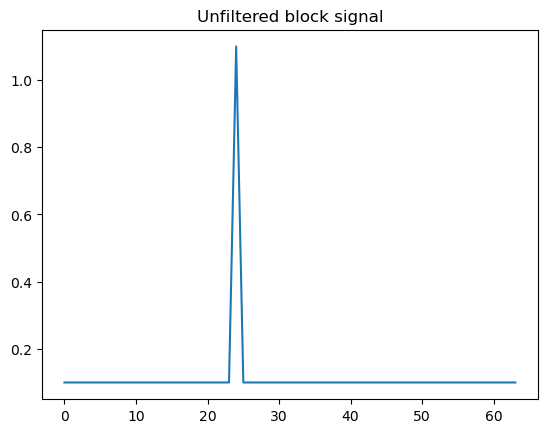

0.115625


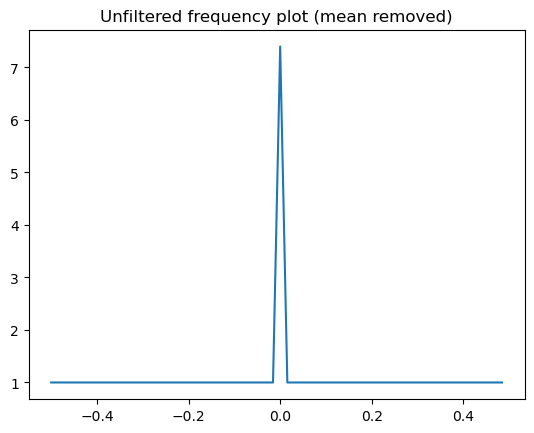

i am sos [[ 0.01031287  0.02062575  0.01031287  1.         -0.32211918  0.04239958]
 [ 1.          2.          1.          1.         -0.36952738  0.19581571]
 [ 1.          2.          1.          1.         -0.49595412  0.60494124]]


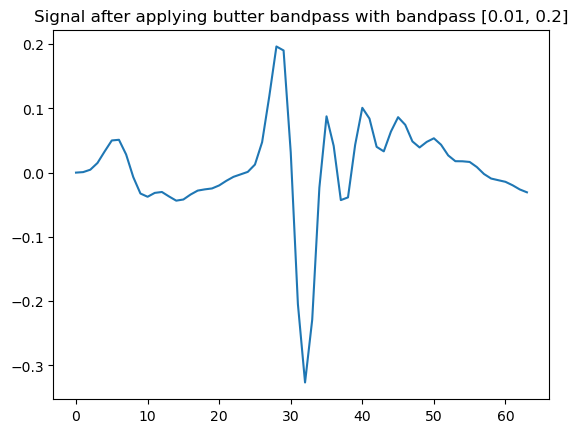

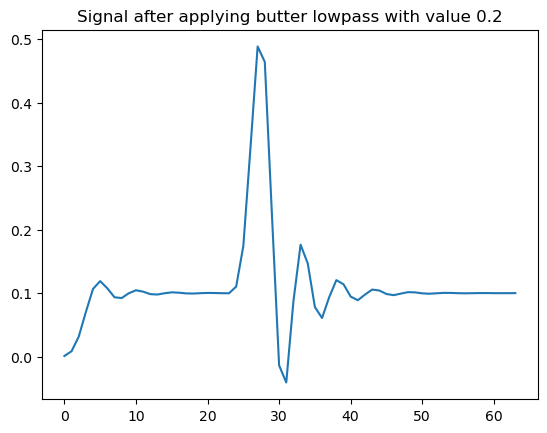

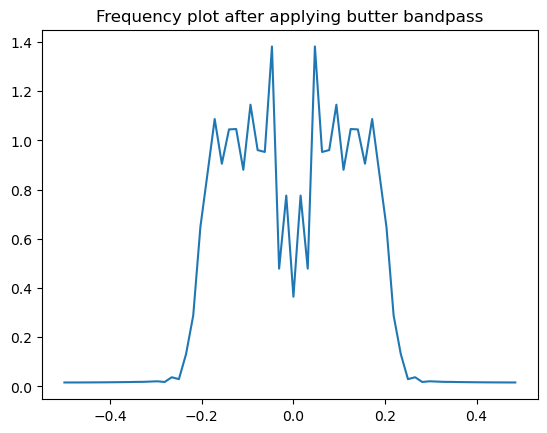

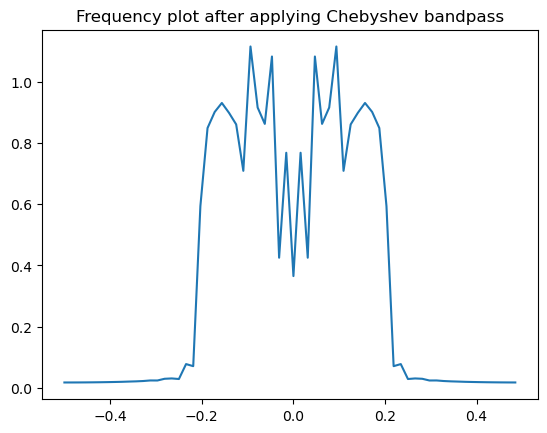

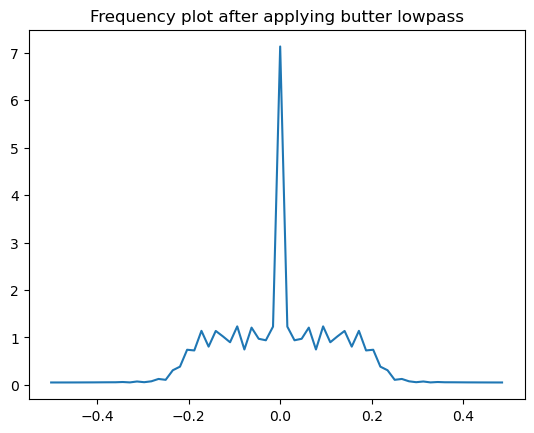

In [31]:
# test the butterworth (bandpass, lowpass) and chebyshev filter 
# first want to know what to cut off from our signal
index = 99
plt.figure()
plt.plot(np.linspace(0,n-1,n), X[index,:])
plt.title("Unfiltered block signal")
plt.show()

mean = np.mean(X[index])
print(mean)
X[index] = X[index] #- mean #note no longer threshold tho
X_fft = fft(X[index])
amplitudes = abs(X_fft)
k = fftfreq(64,1)

sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes = amplitudes[sorted_indices]

plt.figure()
plt.plot(k, amplitudes)
plt.title("Unfiltered frequency plot (mean removed)")
plt.show()

low = 0.01
high = 0.2
y = butter_bandpass_filter(X[index],low,high,1, order = 9)
y2 = chebyshev_bandpass_filter(X[index],low,high,1,order=6)
y3 = butter_lowpass_filter(X[index],high,1,order = 6)

amplitudes1 = abs(fft(y))
amplitudes1 = amplitudes1[sorted_indices]
amplitudes2 = abs(fft(y2))
amplitudes2 = amplitudes2[sorted_indices]
amplitudes3 = abs(fft(y3))
amplitudes3 = amplitudes3[sorted_indices]

plt.figure()
plt.plot(np.linspace(0, n-1, n), y)
plt.title(f"Signal after applying butter bandpass with bandpass [{low}, {high}]")
plt.show()

plt.figure()
plt.plot(np.linspace(0, n-1, n), y3)
plt.title(f"Signal after applying butter lowpass with value {high}")
plt.show()

plt.figure()
plt.plot(k,amplitudes1)
plt.title("Frequency plot after applying butter bandpass")
plt.show()

plt.figure()
plt.plot(k,amplitudes2)
plt.title("Frequency plot after applying Chebyshev bandpass")
plt.show()

plt.figure()
plt.plot(k,amplitudes3)
plt.title("Frequency plot after applying butter lowpass")
plt.show()


##### Bandpassed signals

0.1675179470700532


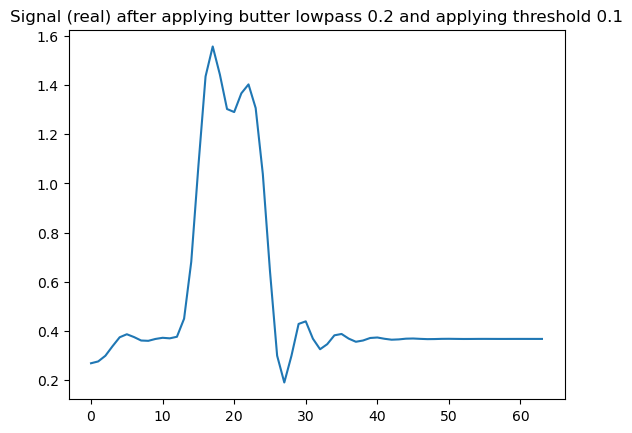

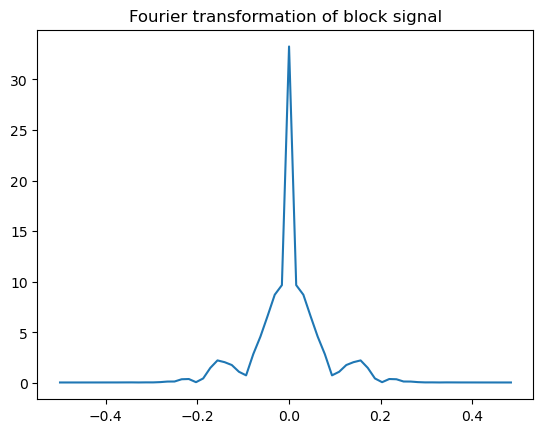

In [13]:
# lowpass works fine without removing means
high = 0.2
order = 6
X_filtered = butter_lowpass_filter(X,high, 1, order = order)
kndex = 9

# threshold
delta = 0.1
min_value = np.abs(X_filtered.min())
print(min_value)
X_filtered = X_filtered + delta + min_value

# sort k
amplitudes_filtered = abs(fft(X_filtered[kndex,:]))
k = fftfreq(64,1)
sorted_indices = np.argsort(k)
k = k[sorted_indices]
amplitudes_filtered = amplitudes_filtered[sorted_indices]

# example plot
plt.figure()
plt.plot(np.linspace(0, n-1, n), X_filtered[kndex,:])
plt.title(f"Signal (real) after applying butter lowpass {high} and applying threshold {delta}")
plt.show()

plt.figure()
plt.plot(k,amplitudes_filtered)
plt.title("Fourier transformation of block signal")
plt.show()


##### Case for real block signal

0.0037841236134364786


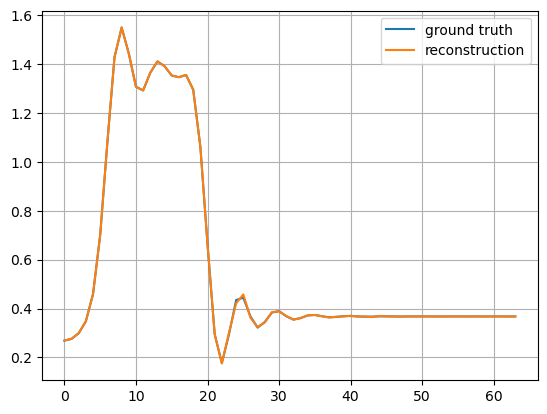

In [27]:
xtrue = X_filtered[8,:] 
sigma = 0
#yobs  = np.abs((MF @ xtrue)**2) + sigma*np.random.randn(64*100)
#print(len(yobs))

#val, grad = objective_1D(np.ones(64), yobs, MF)

error, zhat = reconstruct(xtrue, A, I, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.figure()
plt.plot(domain, np.real(xtrue), label = 'ground truth')
plt.plot(domain, np.real(zhat), label = 'reconstruction')
plt.grid()
plt.legend()

##### Complex block signal

0.002187280033753225


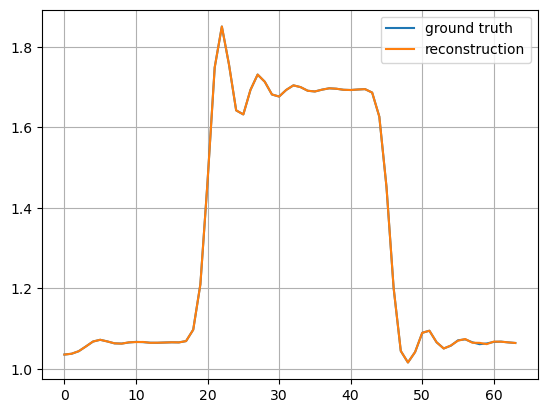

In [53]:
X_complex = np.ones((180,64)) + 1j*X_filtered
xtrue = X_complex[8,:]
sigma = 0

error, zhat = reconstruct(xtrue, A, I, sigma = sigma)
print(error)

domain = np.linspace(0,63,64)
plt.figure()
plt.plot(domain, np.abs(xtrue), label = 'ground truth') 
plt.plot(domain, np.abs(zhat), label = 'reconstruction')
plt.grid()
plt.legend()